## ProjF2 - Aircraft Maintenance (Exploratory Analysis)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

### 1. Load and Visualize Data

Let's start by loading your entire dataset.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
index_names = ['engine_number', 'time_cycles']
setting_names = ['op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_names=['sensor_measurement{}'.format(i+1) for i in range(0,23)]
col_names = index_names + setting_names + sensor_names
rul_names = ['RUL']


train = pd.read_csv("/content/drive/Shared drives/NNDL_Proj/PM_train.txt", header=None, sep=" ",names=col_names)
test = pd.read_csv("/content/drive/Shared drives/NNDL_Proj/PM_test.txt", header=None, sep=" ",names=col_names)

In [ ]:
s1 = pd.merge(train, test, how='inner')


In [ ]:
s1.shape

(0, 28)

In [ ]:
train.head()

,engine_number,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_measurement1,sensor_measurement2,sensor_measurement3,sensor_measurement4,sensor_measurement5,...,sensor_measurement14,sensor_measurement15,sensor_measurement16,sensor_measurement17,sensor_measurement18,sensor_measurement19,sensor_measurement20,sensor_measurement21,sensor_measurement22,sensor_measurement23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [ ]:
test['engine_number'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [ ]:
train.dropna(axis=1, inplace=True)

#s1,s2...s21 corresponds to the different sensor readings
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train.columns = cols_names

In [ ]:
### Generating Classification Target Variable
train.sort_values(['id','cycle'], inplace=True)

# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(train.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_rul = train.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
train_rul['RUL'] = train_rul['max'] - train_rul['cycle']

# We do not need "max" anymore.
train_rul.drop('max', axis=1, inplace=True)

# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 30
train_rul['failure_within_w1'] = np.where(train_rul['RUL'] <= w1, 1, 0 )

In [ ]:
### Normalize Training Dataset

# Make a separate feature for the normalized value of the cycle column.
train_rul['cycle_norm'] = train_rul['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_rul.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_rul = pd.DataFrame(min_max_scaler.fit_transform(train_rul[cols_normalize]),
                             columns=cols_normalize,
                             index=train_rul.index)

#Join the normalized and non-normalized data.
join_df = train_rul[['id','cycle','RUL','failure_within_w1']].join(norm_train_rul)
train_rul = join_df.reindex(columns = train_rul.columns)

## Plotting the Failure point of each Engine


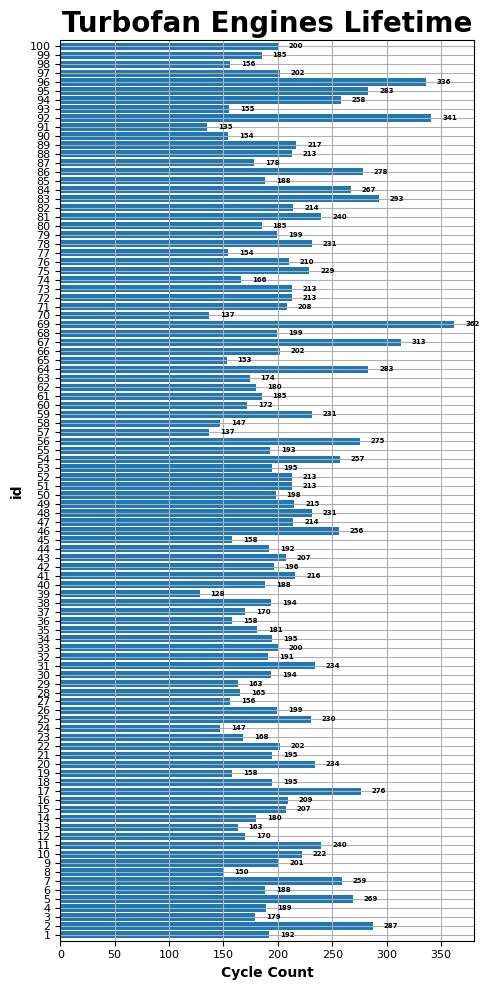

In [ ]:
### Horizontal Bar chat
def plot_time_cycles(data_frame, index_column, value_column, figsize=(5, 10), save_filename=None):
    time_cycles = data_frame.groupby(index_column)[value_column].max()

    plt.figure(figsize=figsize)
    ax = time_cycles.plot(kind='barh', stacked=True, width=0.8, align='center')

    plt.title('Turbofan Engines Lifetime', fontweight='bold', size=20)
    plt.xlabel('Cycle Count', fontweight='bold', size=10)
    plt.ylabel(index_column, fontweight='bold', size=10)
    plt.xticks(size=8)
    plt.yticks(size=8)
    plt.grid(True)

    # To annotate each bar with cycle of failure at end
    for i, v in enumerate(time_cycles):
        ax.text(v + 10, i, str(v), color='black', fontweight='bold', va='center', size=5)

    plt.tight_layout()
    plt.show()

plot_time_cycles(train, index_column='id', value_column='cycle', figsize=(5, 10))

# Monitoring Sensor Values for an Engine ID
For id = 1, we plot and see how the sensor values change across cycles

<Axes: >

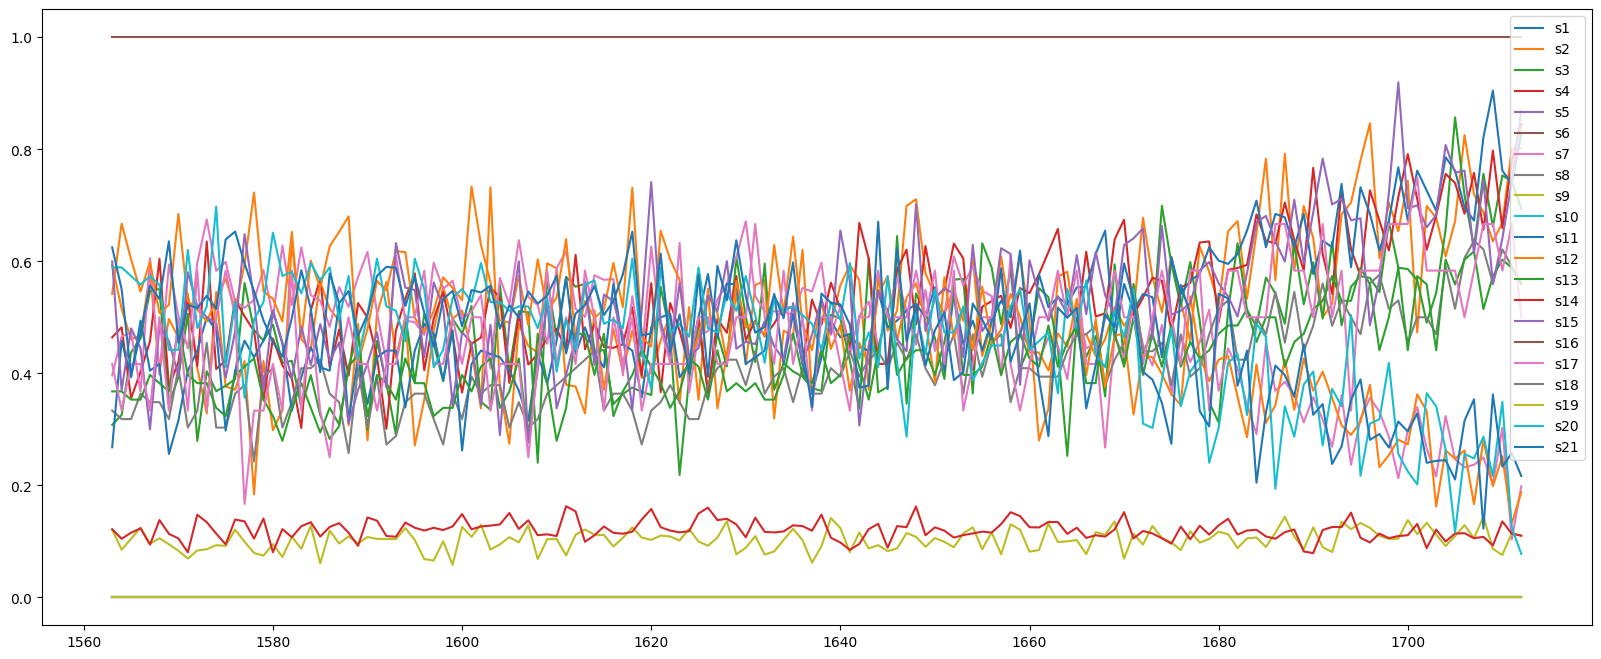

In [ ]:
sensor_cols = cols_names[5:]
train_rul[train_rul.id==8][sensor_cols].plot(figsize=(20, 8))


# 2. Compute Some Statistics from your Data



## Individual Sensor Plot

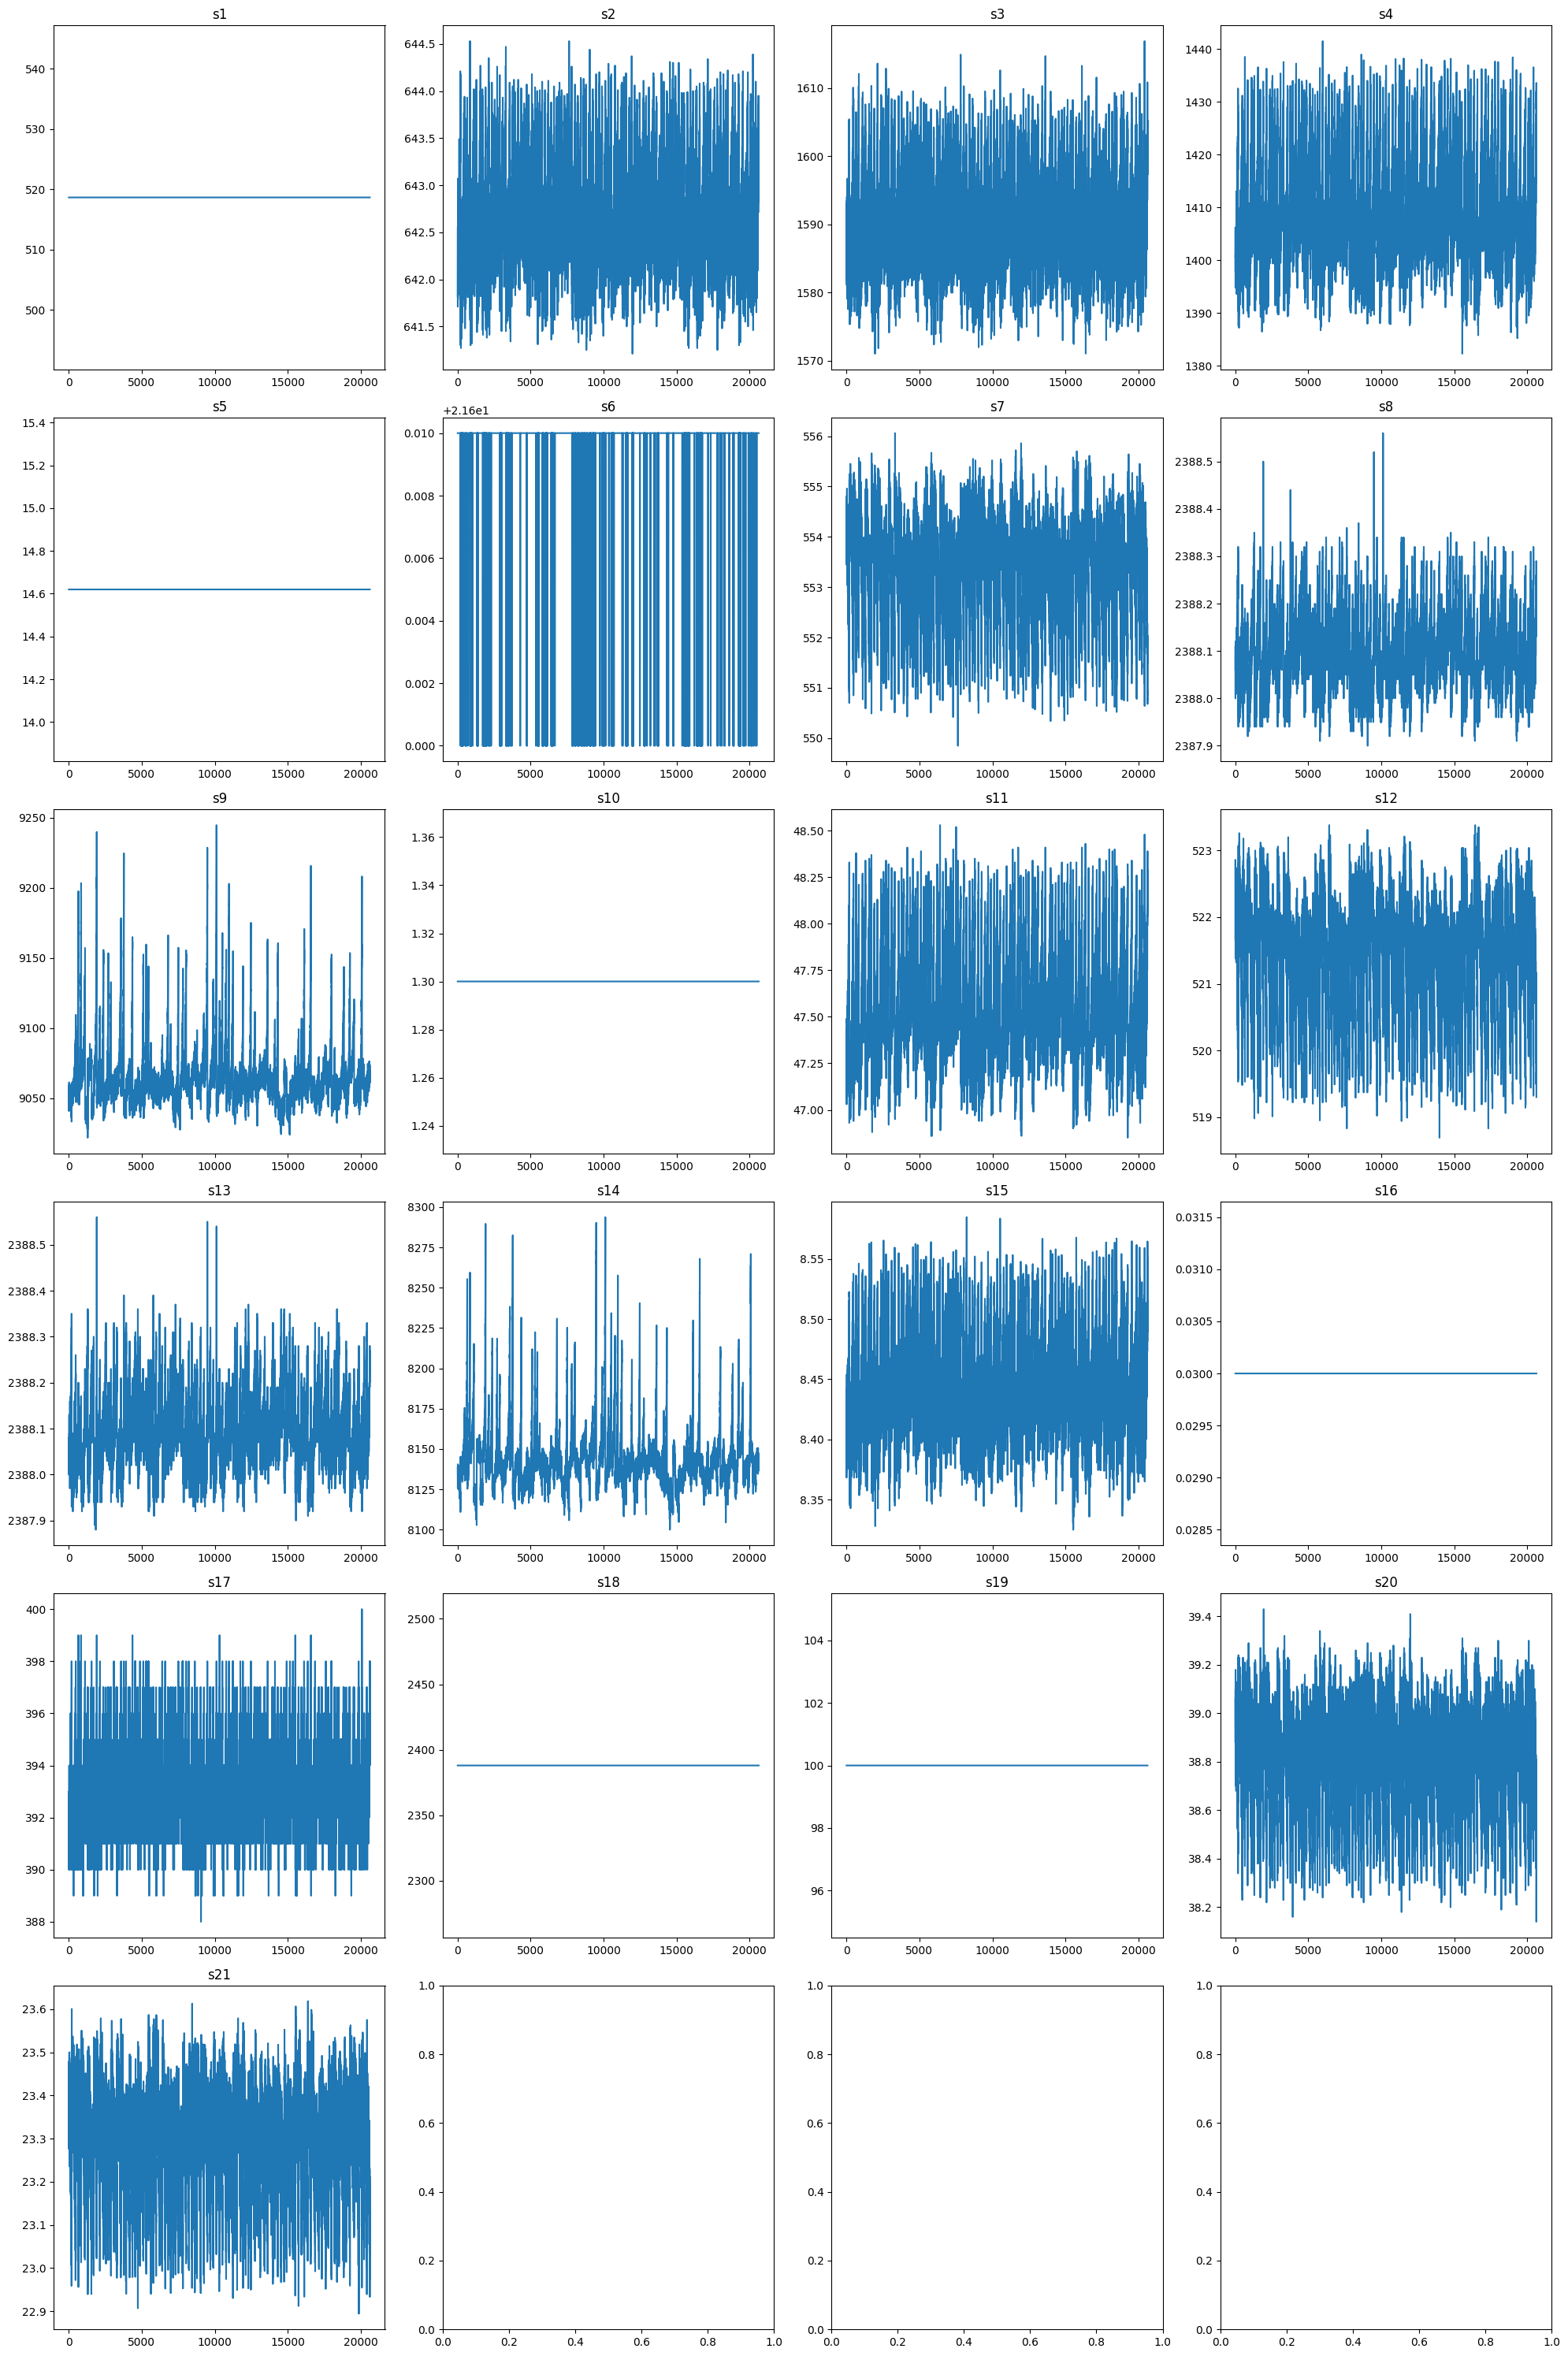

In [ ]:

# Individual sensor plot, plot each sensor against the cycle
columns_to_plot =[ 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
                  's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19',
                   's20', 's21']
num_columns = len(columns_to_plot)

num_rows = (num_columns // 4) + (num_columns % 4 > 0)

fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5))

for i, column in enumerate(columns_to_plot):
    row_index = i // 4
    col_index = i % 4

    axes[row_index, col_index].plot(train[column])
    axes[row_index, col_index].set_title(column)

# Adjust layout
plt.tight_layout()
plt.show()

From the above diagrams, it is evident that not all sensor values provide valuable data. Specifically, sensors **1, 5, 6, 10, 16, 18, and 19** exhibit constant values throughout the cycles. Therefore, these sensor values can be disregarded when constructing the model.

## Engine life

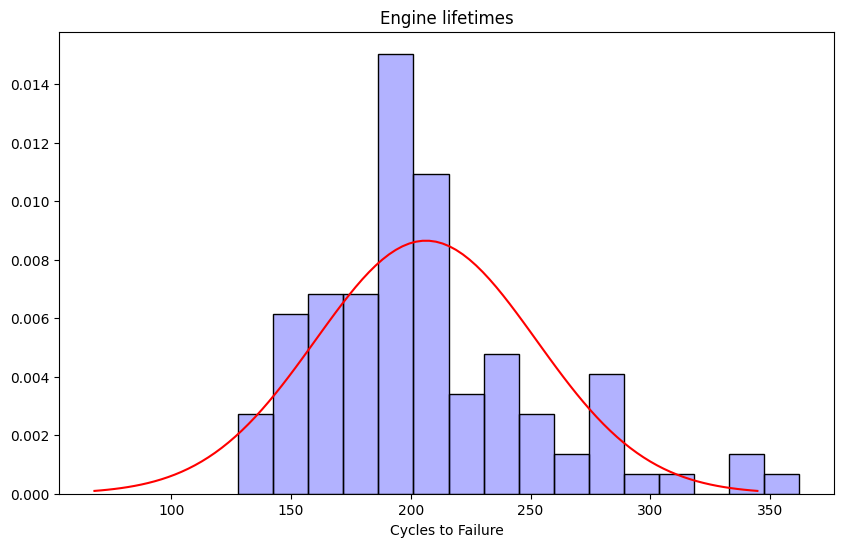


Average lifetime of an engine: 206.31
Lowest lifetime of an engine: 128
Highest lifetime of an engine: 362


In [ ]:
lifetimes_engines = train.groupby('id')['cycle'].max()
mean = np.mean(lifetimes_engines)
std_dev = np.std(lifetimes_engines)

# Generating data for bell curve
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)

# Plotting both the histogram and the bell curve on the same graph
plt.figure(figsize=(10, 6))

# Plotting the histogram with density instead of frequency to match the scale of the bell curve
sns.histplot(lifetimes_engines, bins=16, kde=False, color='blue', stat="density", alpha=0.3)

# Adding the bell curve
plt.plot(x, y, color='red')

plt.title('Engine lifetimes')
plt.xlabel('Cycles to Failure')
plt.ylabel('')

plt.show()
print(f"\nAverage lifetime of an engine: {mean}" )
print(f"Lowest lifetime of an engine: {lifetimes_engines.min()}" )
print(f"Highest lifetime of an engine: {lifetimes_engines.max()}" )

The average lifetime of an engine is noted as 206.31 cycles. <br>
The earliest engine failed after 128 cycles and the engine with the longest life failed after 362.


The histogram illustrates a right-skewed distribution pattern for engine lifetimes, indicating a greater number of early failures relative to those enduring past the mean lifespan, and a sparse occurrence of outliers with significantly prolonged operational durations.

In [ ]:
lifetimes_engines

id
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: cycle, Length: 100, dtype: int64

Text(0.5, 9.444444444444459, 'max time cycle')

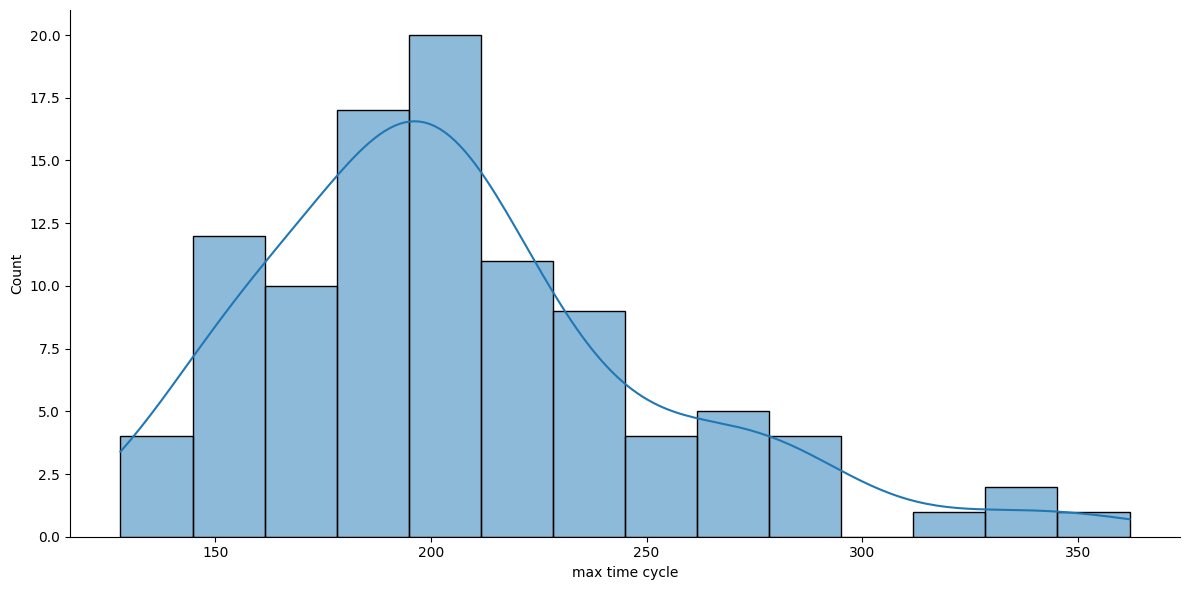

In [ ]:
sns.displot(lifetimes_engines,kde=True,bins=14,height=6,aspect=2)
plt.xlabel('max time cycle')


## Coorelation Matrix for Sensors and Settings

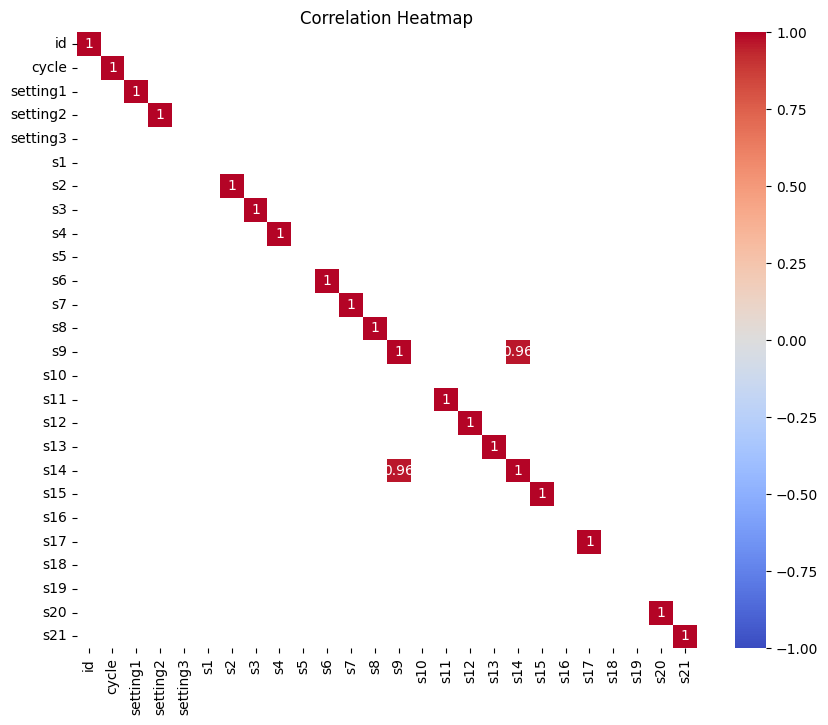

In [ ]:

correlation_matrix = train.corr()

threshold = 0.90
mask = correlation_matrix.applymap(lambda x: abs(x) > threshold)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[mask], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In our correlation matrix, we identified a clear relationship between **sensors 9 and 14** (threshold greater than 0.9), as indicated by the cooler color (red) marking in the correlation matrix. This signifies a strong positive correlation between the two sensors: when sensor 9's readings increase, those of sensor 14 also tend to increase, and vice versa. Therefore, we can simplify our model by ignoring either 9 or **14**

## Correlation Matrix for RUL

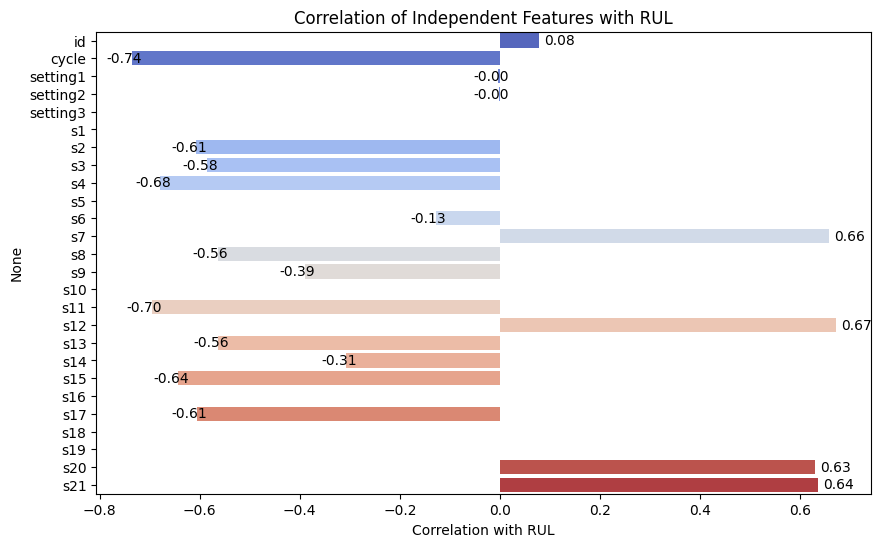

In [ ]:
# Correlation heatmap with RUL - Amrita
# Calculate the correlation matrix
correlation_heatmap = train_rul.drop(columns=['failure_within_w1', 'cycle_norm']).corr()

# Calculate the correlations between independent features and 'RUL'
correlations_with_RUL = correlation_heatmap['RUL'].drop('RUL')  # Exclude the 'RUL' row

# Create a bar plot for correlations with 'RUL' with annotations
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=correlations_with_RUL.values, y=correlations_with_RUL.index, hue=correlations_with_RUL.index, palette='coolwarm', legend=False)
plt.xlabel('Correlation with RUL')
plt.title('Correlation of Independent Features with RUL')

# Add numerical annotations
for i, v in enumerate(correlations_with_RUL.values):
  if not pd.isnull(v):
    ax.text(v + 0.01 if v >= 0 else v - 0.05, i, f'{v:.2f}', color='black', va='center')

plt.show()

The settings (setting1, setting2, and setting3) show no correlation with the dependent variable RUL. Sensor measurement 9 exhibits a higher correlation with RUL compared to Sensor measurement 14. Therefore, we can remove setting1, setting2, setting3, and s14 features.

### 3. Comment on Your Data


- Is your data balanced?

In our scenario, we're working with a time series dataset. In terms of balance, we're in good shape because we have a sufficient number of parameters (21 sensors + 3 settings) to assess the performance of each engine cycle. Additionally, we've been provided with a test dataset, complete with truth values, which allows us to validate our model once it's built.

- Are there disparities in your input data? Does it show some specific patterns?

During our exploratory analysis, we observed that certain sensors consistently held constant values, rendering them uninformative. Consequently, we can disregard these sensors. Additionally, we sought to identify sensors exhibiting a direct relationship, wherein an increase in one sensor reading corresponded with an increase in another sensor reading. Moreover, we observed a correlation between sensor measurements and the engine's life cycle. As the cycles increased, we noted a specific group of sensors displaying increased readings, while another group exhibited a decrease in readings.